# Investigate a Dataset

## Baseball Data

I analyzed the Baseball Databank data in this report.<br>
Instead of download data from [SeanLahman.com](http://www.seanlahman.com/baseball-archive/statistics/),
I clone the Chadwick Baseball Bureau's version from [GitHub]((https://github.com/chadwickbureau/baseballdatabank)
as a submodule.

## Questions

In baseball, a home run is one of the most stimulating things.
Home run is also one of the most efficient way to score by clear the bases in one play.
When talking about great hitters, it is common to look at how many home runs they hit.
But what about the doubles and triples, the base on balls (walk), or the sacrifice fly?

In Sabermetrics, there are some advanced methods to measure a hitter's performance in general.
I won't apply those techniques here, but simply analyze the relation between home run and other batting stats.
Let me start by looking at the data to see what is there.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import read_csv

def read_data(file_name):
    return read_csv('baseballdatabank/core/' + file_name)

batting = read_data('Batting.csv')

def print_dtypes(name, data):
    print "Data types of {}:\n{}\n".format(name, data.dtypes)

print_dtypes('batting stats', batting)

Data types of batting stats:
playerID     object
yearID        int64
stint         int64
teamID       object
lgID         object
G             int64
AB            int64
R             int64
H             int64
2B            int64
3B            int64
HR            int64
RBI         float64
SB          float64
CS          float64
BB            int64
SO          float64
IBB         float64
HBP         float64
SH          float64
SF          float64
GIDP        float64
dtype: object



Here I want to group batting stats by *playerID* and *yearID*.
Because a player may transfer to another team of league during the season.
To make it simple, I will some factors like AL-NL gap or park factor.
Just ignore *stint*, *teamID*, and *lgID*.

In [2]:
batting_raw = batting
# sum up batting stats, teamID and lgID won't be summed but stint will, so drop it explicitly
batting = batting.groupby(['playerID', 'yearID']).sum().drop('stint', axis=1).reset_index()

def print_sample(name, data, n=3):
    print 'Samples of {}:\n{}\n'.format(name, data.sample(n))

print_sample('batting stats', batting)

Samples of batting stats:
        playerID  yearID    G   AB   R    H  2B  3B  HR   RBI    SB    CS  BB  \
35846   hartbu01    1901   58  206  33   64   3   5   0  23.0   7.0   NaN  20   
60868  murcebo01    1970  159  581  95  146  23   3  23  78.0  15.0  10.0  87   
22925   drewst01    2015  131  383  43   77  16   1  17  44.0   0.0   2.0  37   

          SO  IBB  HBP   SH   SF  GIDP  
35846    NaN  NaN  4.0  3.0  NaN   NaN  
60868  100.0  5.0  2.0  4.0  6.0   7.0  
22925   71.0  1.0  1.0  4.0  3.0   7.0  



## HR

Take a look at home runs statistics first.

Summary:
count    95250.000000
mean         3.037092
std          6.560156
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         73.000000
Name: HR, dtype: float64



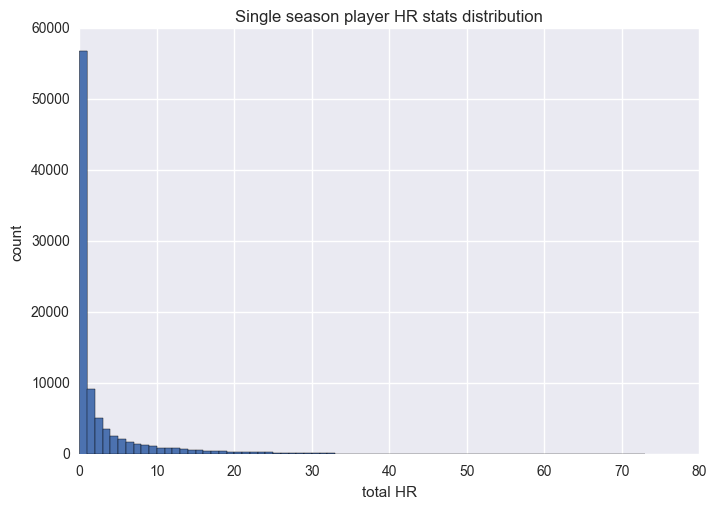

In [3]:
def print_summary(data):
    print "Summary:\n{}\n".format(data.describe())

print_summary(batting['HR'])
ax = batting['HR'].hist(bins=batting['HR'].max())
ax.set_xlabel("total HR")
ax.set_ylabel("count")
ax.set_title("Single season player HR stats distribution")
plt.show()

## Double & Triple

To hit a double or triple, a batter need not only power but skill.
So that he can hit the ball into the "hole" between defensive players.
And a player should also run the bases well or he may end up be tagged out.

Is there any missing value in 2B&3B? False

Summary:
count    95250.000000
mean         8.184714
std         11.973595
min          0.000000
25%          0.000000
50%          2.000000
75%         13.000000
max         77.000000
Name: 2B&3B, dtype: float64



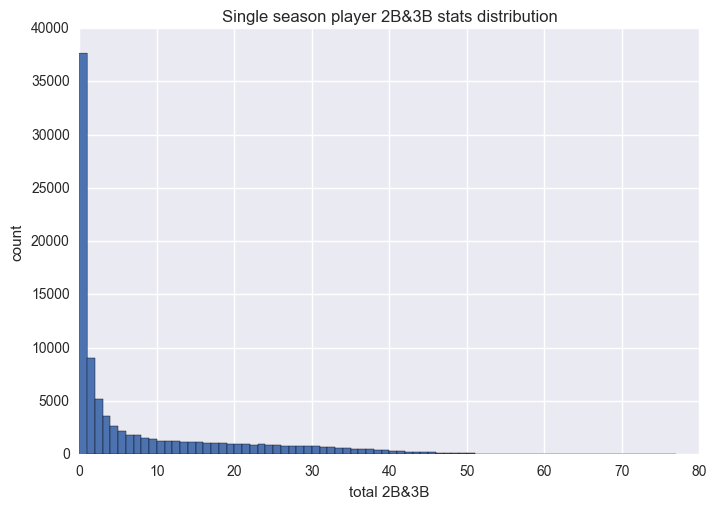

In [4]:
batting['2B&3B'] = batting['2B'] + batting['3B']

def print_hasnans(name, series):
    print "Is there any missing value in {}? {}\n".format(name, series.hasnans)

print_hasnans('2B&3B', batting['2B&3B'])  # should not have missing values
print_summary(batting['2B&3B'])
ax = batting['2B&3B'].hist(bins=batting['2B&3B'].max())
ax.set_xlabel("total 2B&3B")
ax.set_ylabel("count")
ax.set_title("Single season player 2B&3B stats distribution")
plt.show()

## Minimum PA

I saw the leftmost bins are very tall in both *HR* and *2B&3B*.
The half of *HR* and one-fourth *2B&3B* have a 0 on the record.
Maybe some players did not get enough at bats.
Set a minimum qualification standard may help.

In baseball statistics, the "plate appearance"(PA) are counted for each time a batter completes batting.
The *PA* is not in the data, but I can calculate it by the definition: *PA* = *AB* + *BB* + *HBP* + *SH* + *SF*.
I may try the 502 *PA* minimum requirement for current batting title here.

In [5]:
PA = batting['AB'] + batting['BB'] + batting['HBP'] + batting['SH'] + batting['SF']
print_hasnans('PA', PA)

Is there any missing value in PA? True



## Missing Values

The result of *PA* has missing values, something is wrong in the five columns summed up to *PA*.

In [6]:
def print_number_of_missing_value(data):
    missing_value_count = data.shape[0] - data.count()
    print "Number of missing values:\n{}\n".format(missing_value_count)

print_number_of_missing_value(batting[['AB', 'BB', 'HBP', 'SH', 'SF']])

Number of missing values:
AB         0
BB         0
HBP     2514
SH      5730
SF     33469
dtype: int64



The *HBP*, *SH*, and *SF* columns have various amount of missing values.
And the count of missing *SF* is very large.
I searched for sacrifice fly on Google, and found a reasonable answer from [MLB.com](http://m.mlb.com/glossary/standard-stats/sacrifice-fly):
"The sacrifice fly was adopted as an official rule in 1954, at which point it was distinguished from the sacrifice bunt."
So I decided to make some plot to help me find the pattern of missing values.

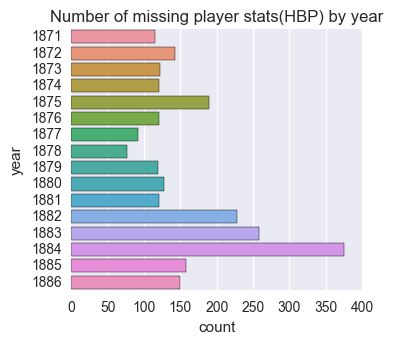

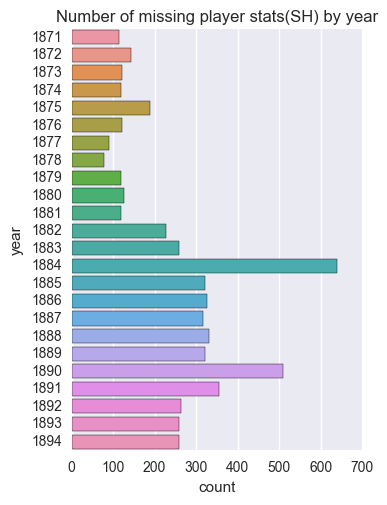

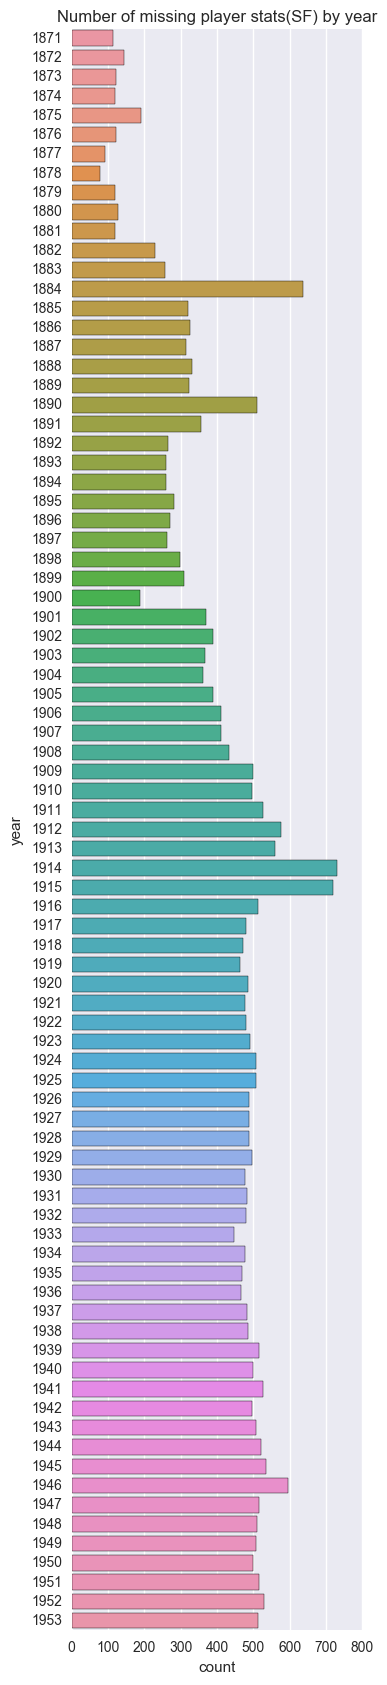

In [7]:
for column in ['HBP', 'SH', 'SF']:
    data = batting[batting[column].isnull()]
    size = data['yearID'].nunique()*4/20.0
    aspect = 4/size
    g = sns.factorplot(y='yearID', data=data, kind='count', size=size , aspect=aspect)
    g.set_axis_labels("count", "year")
    g.ax.set_title("Number of missing player stats({}) by year".format(column))
    plt.show()

## Rule Changes

So all the missing hit by pitch is before 1887, and all the missing sacrifice hit(bunt) is before 1895.
I searched on Google again and found other [rule changes](http://www.baseball-almanac.com/rulechng.shtml) may lead to those missing values.
In 1887, the batter was awarded first base when hit by a pitch.
A sacrifice bunt was statistically recognized start from 1889.
And then the some rules related to bunt changed in 1893 and 1894.
It all make sense.
I think it is fine to fill all the missing values with 0.

In [8]:
PA = batting['AB'] + batting['BB'] + batting['HBP'].fillna(0) + batting['SH'].fillna(0) + batting['SF'].fillna(0)
print_hasnans('PA', PA)

Is there any missing value in PA? False



## Sampling

Before make decision for minimum requirement *PA*, I am aware that *PA* may cause a problem.
For two players both hit 20 home runs in a season, have 600 and 400 *PA* respectively, who has the better batting performance?
To answer this question, I want to describe the baseball batting stats data with statistical terms first and define the sample and observation.<br>

If a player's single season performance is a sample, then his each plate appearance is an observation.
I have to divide the record number by *PA* for the sample mean.<br>
And if a player's career performance is a sample, then I can treat his each single season stats as an observation.
In this case, I can get the sample mean by divide career record number by total seasons.<br>
For both cases, the higher sample mean implies the better performance.

Then I divide the cumulative batting stats with *PA*.

In [9]:
batting_per_PA = batting[PA > 0][['playerID', 'yearID']]
batting_per_PA['2B&3B'] = batting[PA > 0]['2B&3B'] / PA[PA > 0]
batting_per_PA['HR'] = batting[PA > 0]['HR'] / PA[PA > 0]
print_number_of_missing_value(batting_per_PA)
print_sample('batting stats per PA', batting_per_PA)

Number of missing values:
playerID    0
yearID      0
2B&3B       0
HR          0
dtype: int64

Samples of batting stats per PA:
        playerID  yearID    2B&3B   HR
59957  morried02    1931  0.02439  0.0
49486  lestejo01    2014  0.00000  0.0
3077   bailebi01    1907  0.00000  0.0



## Refine the Question

So how many *PA* is required?
Let me transform this to another question.
For the loaded dice, how many dices do I need to roll at the same time, so that the every single outcome will reflect the probability of each side?<br>
If I use as many dices as I can, the outcome will more likely to match the real probability.
But I don't want to filter out too many records, or my analysis will lose the generality.
And the most single season *PA* in the MLB history is 778.
So I decide to choose 100 *PA* minimum, and refine my question as below.

**For hitters with more than 100 *PA* in the single season, is there a linear relationship between the rate of home run and the rate of double & triple, walk, sacrifice fly, or runs battered in?**

Number of missing values:
playerID    0
yearID      0
2B&3B       0
HR          0
BB          0
SF          0
RBI         0
dtype: int64

Samples of batting stats per PA:
        playerID  yearID     2B&3B        HR        BB        SF       RBI
788    aldremi01    1995  0.046512  0.023256  0.110465  0.017442  0.139535
30957  glaznwh01    1920  0.000000  0.000000  0.000000  0.000000  0.000000
68295  planked01    1901  0.000000  0.000000  0.045045  0.000000  0.027027

Summary:
                 HR         2B&3B            BB            SF           RBI
count  39298.000000  39298.000000  39298.000000  39298.000000  39298.000000
mean       0.016645      0.047015      0.080975      0.004254      0.104742
std        0.015963      0.016840      0.036678      0.005423      0.038885
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.003854      0.035886      0.055285      0.000000      0.077703
50%        0.011960      0.046687      0.077670      0.000000  

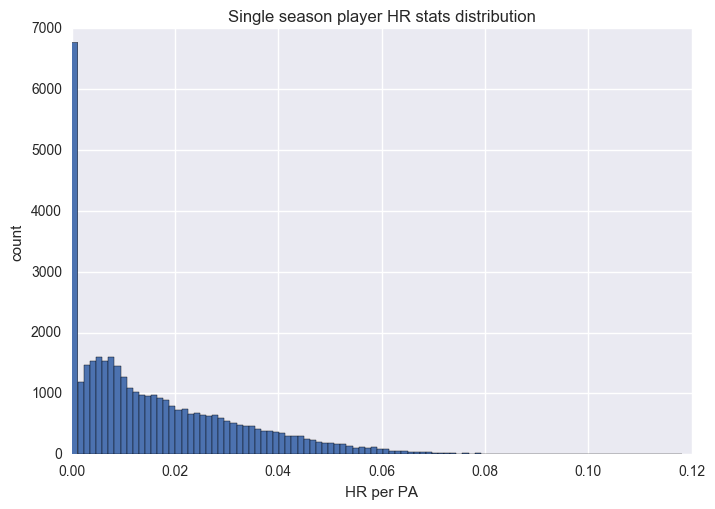

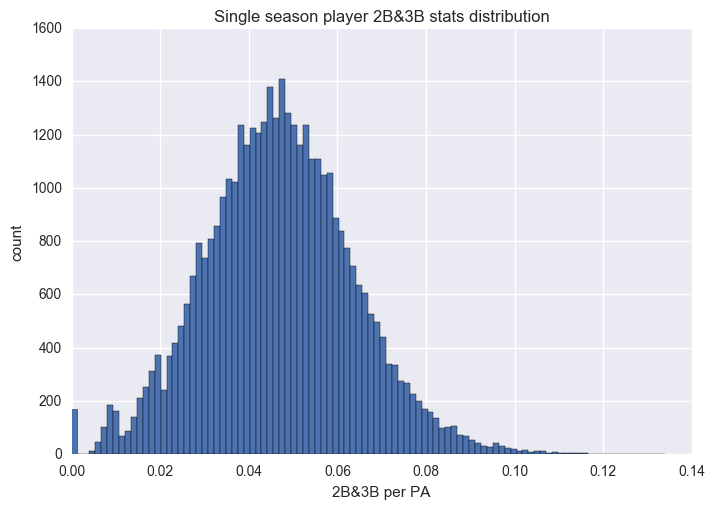

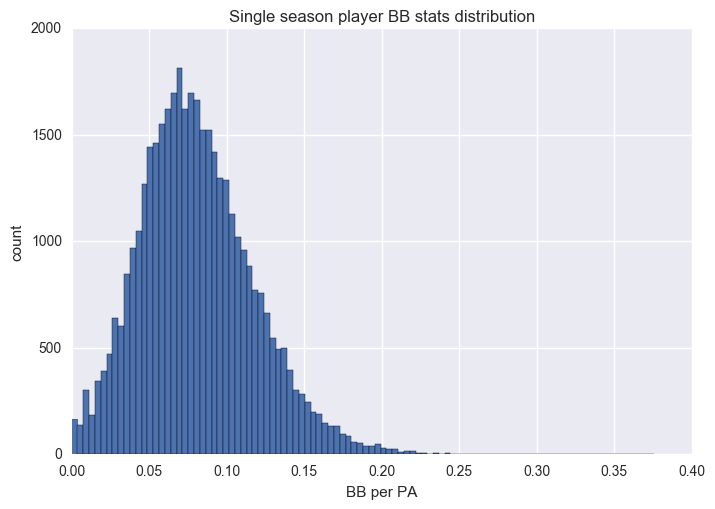

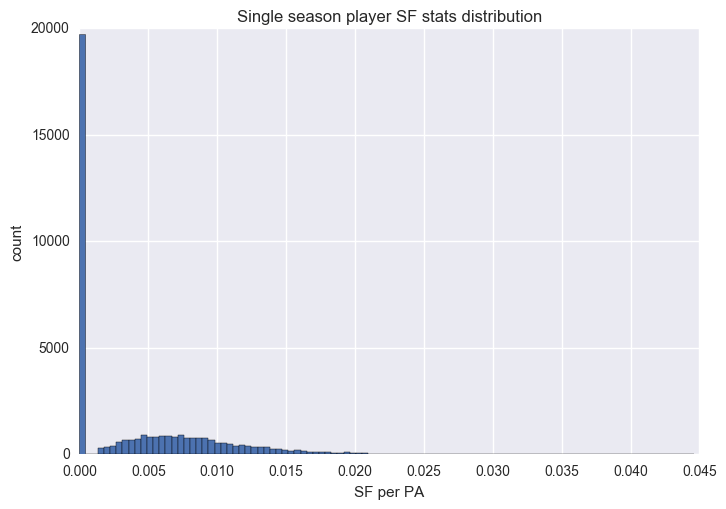

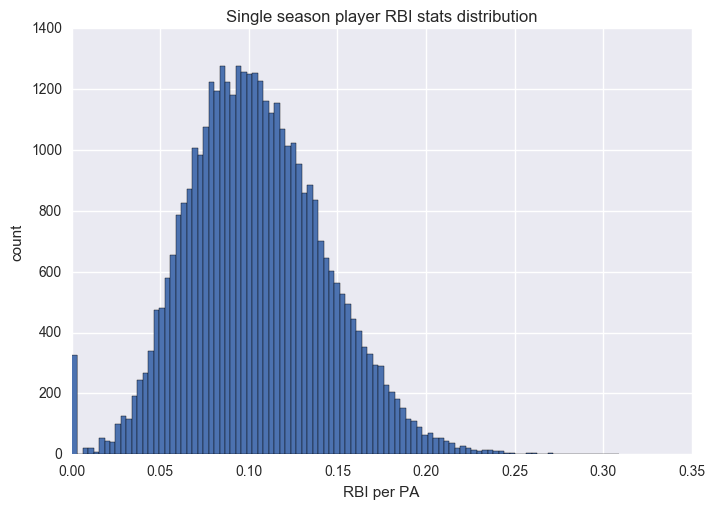

In [10]:
batting_per_PA['BB'] = batting[PA > 0]['BB'] / PA[PA > 0]
batting_per_PA['SF'] = batting[PA > 0]['SF'].fillna(0) / PA[PA > 0]
batting_per_PA['RBI'] = batting[PA > 0]['RBI'].fillna(0) / PA[PA > 0]

print_number_of_missing_value(batting_per_PA)
print_sample('batting stats per PA', batting_per_PA)

select = PA[PA > 0] > 100
stats = ['HR', '2B&3B', 'BB', 'SF', 'RBI']
print_summary(batting_per_PA[select][stats])

for name in stats:
    ax = batting_per_PA[select][name].hist(bins=100)
    ax.set_xlabel('{} per PA'.format(name))
    ax.set_ylabel('count')
    ax.set_title('Single season player {} stats distribution'.format(name))
    plt.show()

## Correlation

To answer the question, I want to calculate the correlation coefficient for the average stats first.
And do the hypothesis testing to see if the relationship is stronger in the population.

In [11]:
r = batting_per_PA[select][stats].corr()
print r

             HR     2B&3B        BB        SF       RBI
HR     1.000000  0.148781  0.299612  0.362750  0.630265
2B&3B  0.148781  1.000000 -0.000623  0.012192  0.396748
BB     0.299612 -0.000623  1.000000  0.110106  0.163865
SF     0.362750  0.012192  0.110106  1.000000  0.207468
RBI    0.630265  0.396748  0.163865  0.207468  1.000000


## Hypothesis Testing

The correlation coefficients showed the *HR per PA* has the stronger correlation with *RBI per PA*.
Followed by the *SF per PA* and then *BB per PA*.
The correlation with *2B&3B per PA* is the last.
I assume the true correlation for the population is ρ, then the hypothesis are:

*H*<sub>0</sub> : *ρ* = 0

*H*<sub>a</sub> : *ρ* ≠ 0


In [12]:
import scipy.stats

t = r / (1 - r*r)**0.5 * (39298 - 2)**0.5
print "The t-statistics:\n{}\n".format(t)

def compute_p(data, n):
    return scipy.stats.t.sf(data, n-2)*2

p = t['HR'].apply(compute_p, args=(39298,))
print "P values:\n{}\n".format(p)

mu = batting_per_PA[select][stats].mean()
s = batting_per_PA[select][stats].std()
ti = scipy.stats.t.interval(0.975, 39298 - 2)
print "The 95% confidence interval"
print "lower bound:\n{}".format(mu + ti[0] * s / 39298**0.5)
print "upper bound:\n{}".format(mu + ti[1] * s / 39298**0.5)

The t-statistics:
               HR      2B&3B         BB         SF         RBI
HR            inf  29.825138  62.252498  77.164747  160.924996
2B&3B   29.825138        inf  -0.123482   2.417066   85.680318
BB      62.252498  -0.123482        inf  21.960038   32.928433
SF      77.164747   2.417066  21.960038        inf   42.041620
RBI    160.924996  85.680318  32.928433  42.041620         inf

P values:
HR        0.000000e+00
2B&3B    2.658611e-193
BB        0.000000e+00
SF        0.000000e+00
RBI       0.000000e+00
Name: HR, dtype: float64

The 95% confidence interval
lower bound:
HR       0.016464
2B&3B    0.046824
BB       0.080560
SF       0.004193
RBI      0.104302
dtype: float64
upper bound:
HR       0.016825
2B&3B    0.047205
BB       0.081389
SF       0.004316
RBI      0.105182
dtype: float64


## Strong Relationship?

Clearly, result of 4 t-tests all reject the null, there is significant relationship for the population.
But what is this mean?
The statistic test showed the population have stronger relationship than the sample, but this does not mean there is a linear relationship.
Let me draw the scatter plot.

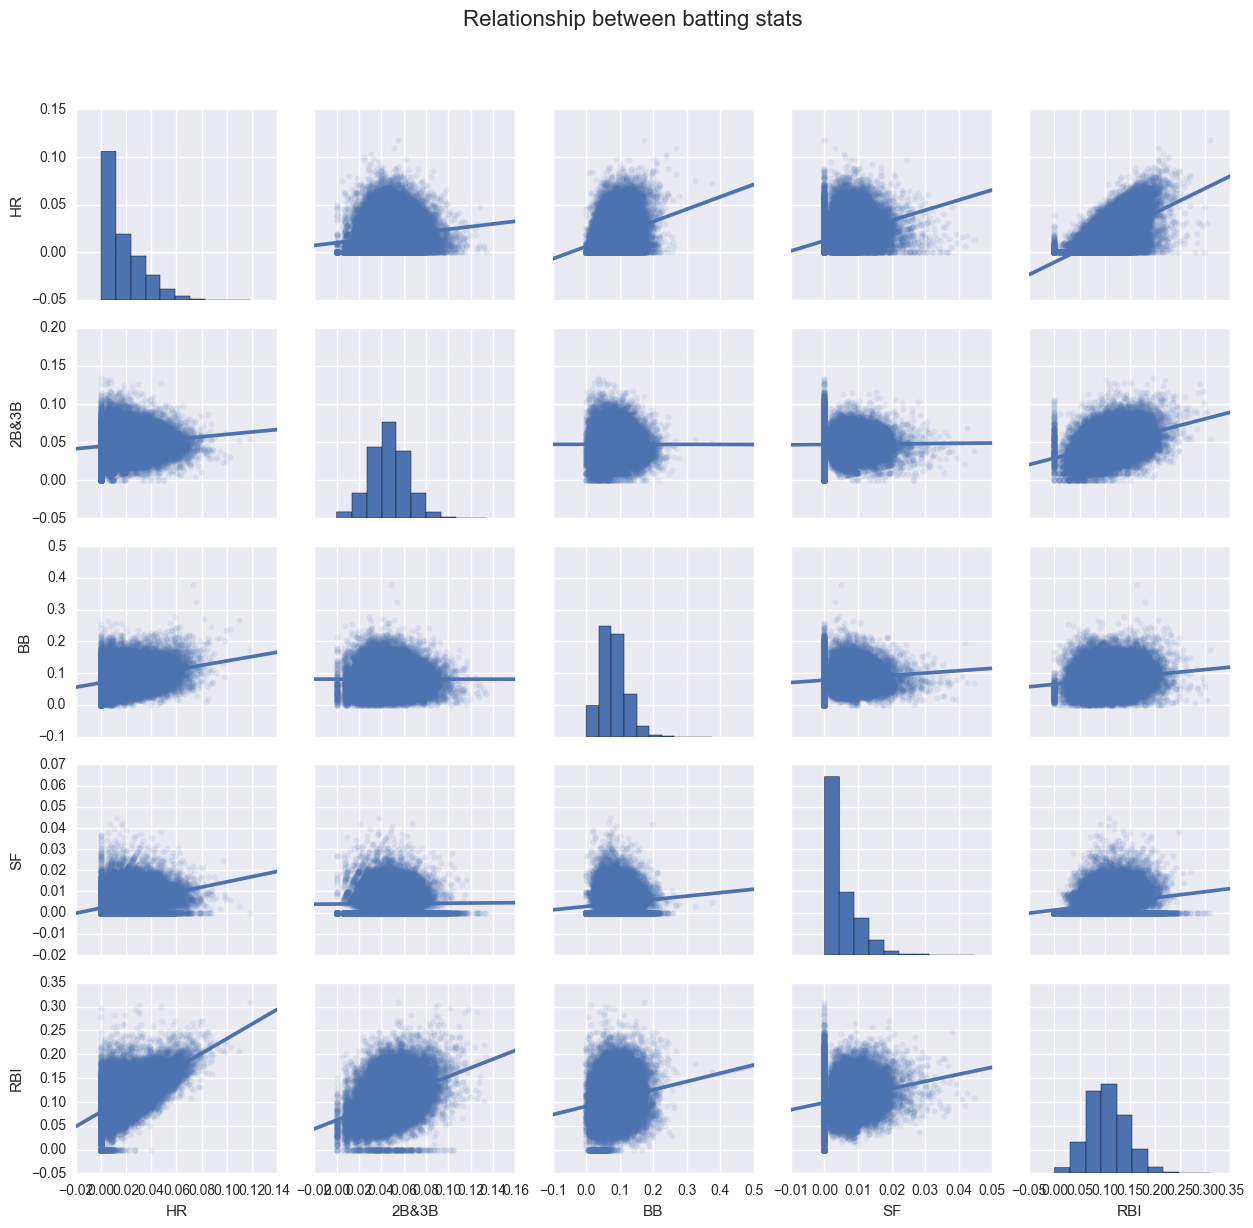

In [13]:
sns.pairplot(batting_per_PA[select][stats], kind='reg', plot_kws=dict(scatter_kws=dict(alpha=0.1)))
plt.suptitle("Relationship between batting stats", fontsize=16)
plt.subplots_adjust(top=0.9)

## My Explanation

You can see the point on each scatter plot does not fit the linear regression line well.
And the correlation coefficients also told me the same.

- 2B&3B per PA<br>
The rate of *2B&3B* and rate of *HR* has the lowest 0.148781 coefficient.
Though I expect there will not be a strong correlation between these two variables, this surprised me.
I though the relationship won't be such weak.<br>
Some reasons caused the result:
  - Different batting skill is required for different kind of long hit. A player need to hit the ball toward the 'hole' between defensive players. Or make the ball go along on sideline. Sometimes he need to know how to utilize the ballpark for hit a ground rule double. A great player can use different skills in different situation, but not all players have all those skills.
  - Power matters. A powerful hitter can launch a line drive go out of the wall. But a line drive by a normal hitter may become a double or get caught by the outfielder.
  - Batting strategy can also affect the result. Some players may focus on specific pitch to crush the ball with a big hit. While some other players try to make contact with every ball in the strike zone.

- BB per PA<br>
I think the plate discipline is totally different with batting skill such as how to swing effectively and smoothly, make contact, or follow through well. But a skilled hitter can benefit from all the skill because the pitcher can't attack him with strike easily. So I think it is normal if the walk has some sort of relationship, but not a strong kind.

- SF per PA<br>
Sacrifice fly and home run are similar that the batter is credited with at least 1 *RBI*. Yes, a [multiple runs sacrifice fly](http://m.mlb.com/news/article/36494110//) is possible. And they are both fly ball. But I have no idea that how the sacrifice fly should related to the home run. The correlation coefficient does not suggest a strong relationship too.

- RBI per PA<br>
The strongest correlation is between home run per *PA* and runs battered in per *PA*.
Consider the fact that every home run always battered at least 1 run, the coefficient 0.630265 is not strong enough.

There may be other some reasons out of my head.
And of course I have no evidence if the reasons I mentioned above is the real or not.
There are all speculation without experiments.

## Conclusion

In this project, I tried to examine the relationship between home run and other batting stats.
I perform the analysis just using the simple average stats.
After a series of exploration and statistic test, I found it is still difficult to conclude whether the relationship exist or not.
Even if the correlation is siginificant, I still can't say higher home run stat leads to better batting ability.
I learned from course that there are lots of counterexamples showed the correlation does not imply causation.
So it is not appropriated using a single stats to evaluate a batter's performance because many factors affect batting.
And that is why baseball statistics have something like Slugging Percentage (SLG) and Isolated Power (ISO) for measuring hitter ability.
Sabermetrics developed many advanced statistics method such as WAR, BABIP, weighted statistics, etc.
It will be interesting to learn more data analysis techniques and think in statistic way, and then invent or perform some advanced method to mine new findings for this everyday sport.